In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set(style="whitegrid")

In [6]:
with open("locomo10.json", "r") as f:
    locomo_data = json.load(f)

[{'qa': [{'question': 'When did Caroline go to the LGBTQ support group?',
    'answer': '7 May 2023',
    'evidence': ['D1:3'],
    'category': 2},
   {'question': 'When did Melanie paint a sunrise?',
    'answer': 2022,
    'evidence': ['D1:12'],
    'category': 2},
   {'question': 'What fields would Caroline be likely to pursue in her educaton?',
    'answer': 'Psychology, counseling certification',
    'evidence': ['D1:9', 'D1:11'],
    'category': 3},
   {'question': 'What did Caroline research?',
    'answer': 'Adoption agencies',
    'evidence': ['D2:8'],
    'category': 1},
   {'question': "What is Caroline's identity?",
    'answer': 'Transgender woman',
    'evidence': ['D1:5'],
    'category': 1},
   {'question': 'When did Melanie run a charity race?',
    'answer': 'The sunday before 25 May 2023',
    'evidence': ['D2:1'],
    'category': 2},
   {'question': 'When is Melanie planning on going camping?',
    'answer': 'June 2023',
    'evidence': ['D2:7'],
    'category': 2},
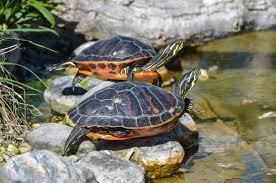
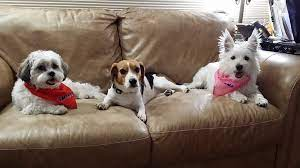

In [11]:
locomo_data

In [7]:
print("Number of conversations:", len(locomo_data))

Number of conversations: 10


In [12]:
# We flatten QA entries to work at the benchmark unit level
# Agent evaluation happens per question, not per conversation
qa_records = []

for convo in locomo_data:
    if "qa" in convo and convo["qa"]:
        for qa in convo["qa"]:
            qa_records.append({
                "question": qa.get("question", ""),
                "answer": qa.get("answer", ""),
                "category": qa.get("category", None),
                "evidence_sessions": len(qa.get("evidence", []))
            })


In [13]:
qa_df = pd.DataFrame(qa_records)

print("Total QA samples:", len(qa_df))
qa_df.head()

Total QA samples: 1986


,question,answer,category,evidence_sessions
0,When did Caroline go to the LGBTQ support group?,7 May 2023,2,1
1,When did Melanie paint a sunrise?,2022,2,1
2,What fields would Caroline be likely to pursue...,"Psychology, counseling certification",3,2
3,What did Caroline research?,Adoption agencies,1,1
4,What is Caroline's identity?,Transgender woman,1,1


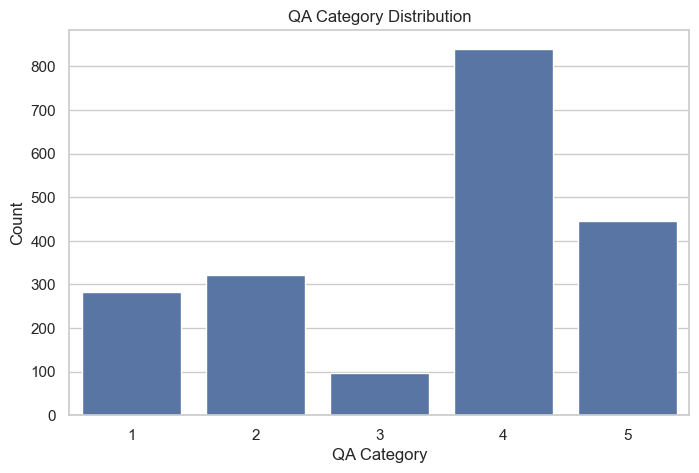

In [ ]:
# Category distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=qa_df, x="category")
plt.title("QA Category Distribution")
plt.xlabel("QA Category")
plt.ylabel("Count")
plt.show()


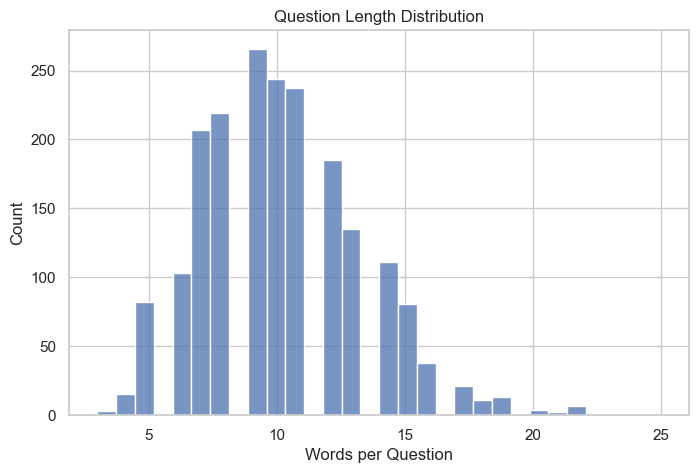

In [15]:
# Question length approximates reasoning and retrieval complexity
qa_df["question_length"] = qa_df["question"].apply(
    lambda x: len(str(x).split())
)

plt.figure(figsize=(8, 5))
sns.histplot(qa_df["question_length"], bins=30)
plt.title("Question Length Distribution")
plt.xlabel("Words per Question")
plt.ylabel("Count")
plt.show()


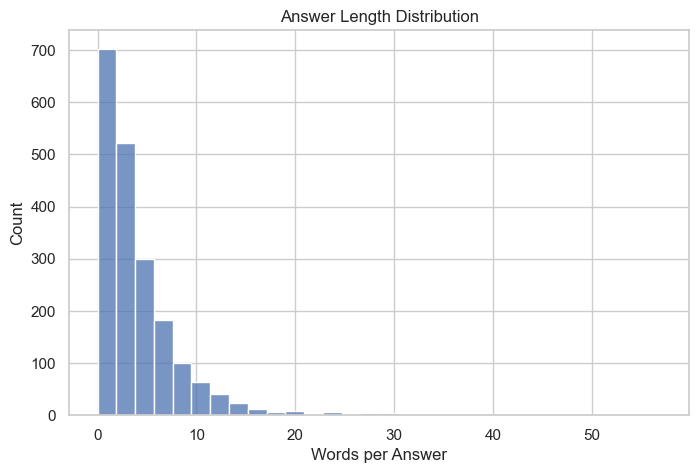

In [16]:
# Answers can be numeric or textual in locomo
qa_df["answer_length"] = qa_df["answer"].apply(
    lambda x: len(str(x).split())
)

plt.figure(figsize=(8, 5))
sns.histplot(qa_df["answer_length"], bins=30)
plt.title("Answer Length Distribution")
plt.xlabel("Words per Answer")
plt.ylabel("Count")
plt.show()


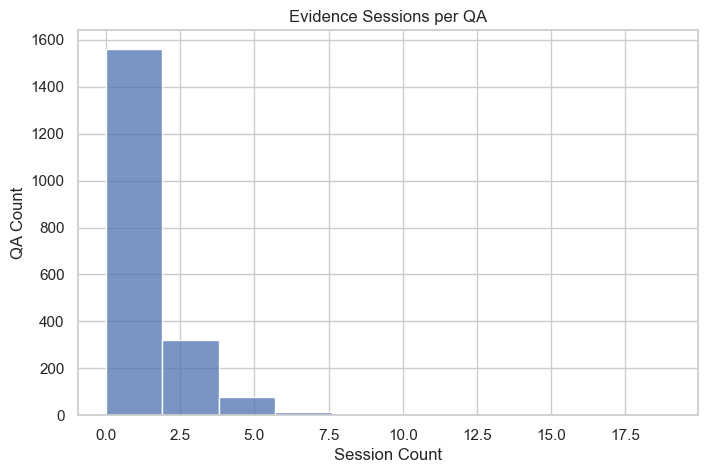

In [17]:
# Now, we look at the evidence session span
# This measures how many sessions an agent must recall from
# It directly reflects long-term memory demand
plt.figure(figsize=(8, 5))
sns.histplot(qa_df["evidence_sessions"], bins=10)
plt.title("Evidence Sessions per QA")
plt.xlabel("Session Count")
plt.ylabel("QA Count")
plt.show()

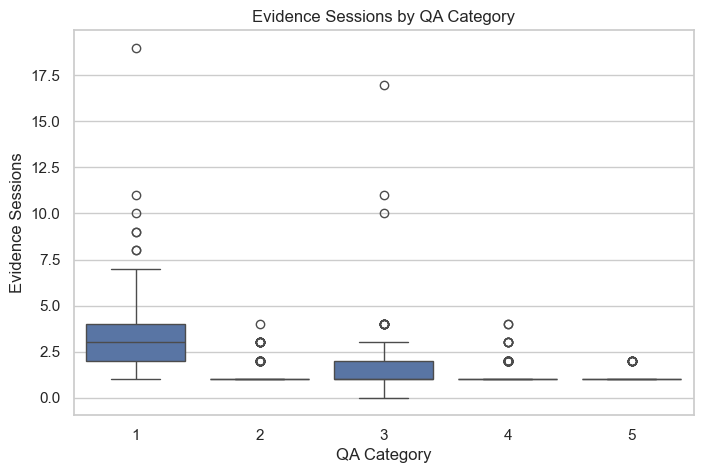

In [18]:
# We'll go by category now to see how these stats vary and which question types stress memory
plt.figure(figsize=(8, 5))
sns.boxplot(data=qa_df, x="category", y="evidence_sessions")
plt.title("Evidence Sessions by QA Category")
plt.xlabel("QA Category")
plt.ylabel("Evidence Sessions")
plt.show()


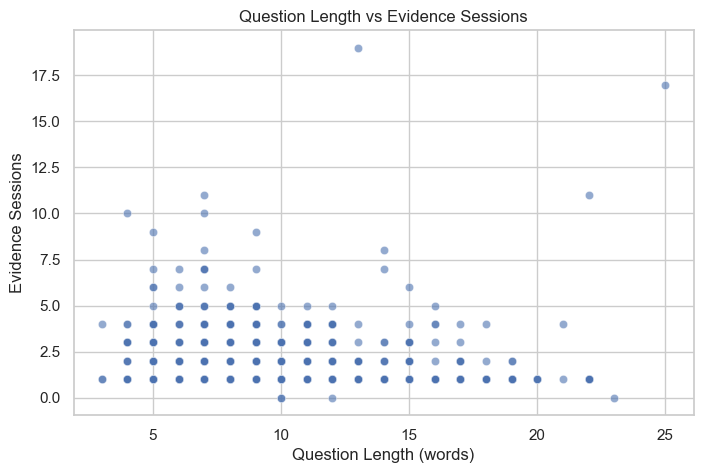

In [ ]:
# Does linguistic complexity align with memory load?
# Helpful for separating reasoning from retrieval difficulty
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=qa_df,
    x="question_length",
    y="evidence_sessions",
    alpha=0.6
)
plt.title("Question Length vs Evidence Sessions")
plt.xlabel("Question Length (words)")
plt.ylabel("Evidence Sessions")
plt.show()


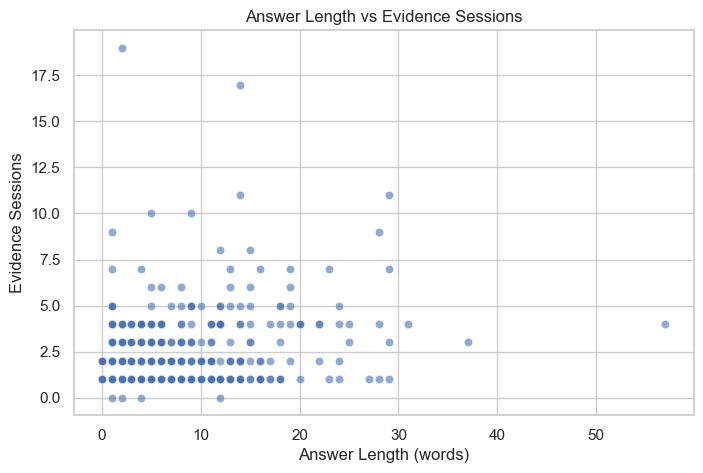

In [23]:
# Longer answers often imply synthesis across events
# This stresses memory integration rather than recall
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=qa_df,
    x="answer_length",
    y="evidence_sessions",
    alpha=0.6
)
plt.title("Answer Length vs Evidence Sessions")
plt.xlabel("Answer Length (words)")
plt.ylabel("Evidence Sessions")
plt.show()

In [25]:
# Short answers with wide evidence spans are easy to miss
# These expose failures in precise long-term recall
thin_signal_qas = qa_df[
    (qa_df["answer_length"] <= 5) &
    (qa_df["evidence_sessions"] >= 3)
]

print("Thin-signal memory QAs:", len(thin_signal_qas))
thin_signal_qas.head()

Thin-signal memory QAs: 94


,question,answer,category,evidence_sessions,question_length,answer_length
15,What activities does Melanie partake in?,"pottery, camping, painting, swimming",1,4,6,4
18,Where has Melanie camped?,"beach, mountains, forest",1,3,4,3
43,What kind of art does Caroline make?,abstract art,1,3,7,2
48,What types of pottery have Melanie and her kid...,"bowls, cup",1,3,10,2
51,What has Melanie painted?,"Horse, sunset, sunrise",1,3,4,3


In [28]:
# This table summarizes memory burden by question type
# Useful for reporting and benchmark stratification
category_profile = qa_df.groupby("category").agg({
    "question_length": "mean",
    "answer_length": "mean",
    "evidence_sessions": "mean",
}).round(2)

print("Category Memory Difficulty Profile:")
category_profile

Category Memory Difficulty Profile:


,question_length,answer_length,evidence_sessions
category,,,
1,8.41,6.27,3.13
2,9.07,3.35,1.17
3,10.61,6.55,2.08
4,10.82,4.83,1.07
5,10.79,0.00,1.03


## Dataset Overview
- The Locomo dataset contains multi-session conversations, each with multiple QA pairs.
- Benchmarking is performed at the QA level, not per conversation.

### 1. Category Distribution
- Observation: Some categories (Temporal, Multi-Hop) dominate, while others are sparse (Open Domain- where Agentmem is struggling).
- Implication: Might have to the stratified benchmark direction? Rare categories may need oversampling or special attention.

### 2. Question & Answer Lengths
- Observation: Both distributions are broad, with a long tail of complex, multi-word questions/answers.
- Implication: The dataset tests both simple recall and advanced synthesis.

### 3. Evidence Sessions
- Observation: Many QAs require evidence from multiple sessions; some demand recall across 3+ sessions.
- Implication: High session span QAs stress memory retention and retrieval. This could be a point where we can outperform the others.

### 4. Category v Memory Burden
- Observation: Boxplots show some categories consistently require more evidence sessions.
- Implication: Benchmarking by category reveals that some question types are most memory intensive, this could be useful for targeted model improvement.

### 5. Linguistic Complexity v Memory Load
- Observation: Scatterplots show only a weak correlation between question/answer length and evidence session count.
- Implication: Reasoning complexity and memory load are not always aligned. Some short questions require deep recall, and vice versa.

### 6. Thin Signal QAs
- Observation: Short answers with high evidence span are rare but critical.
- Implication: These QAs are ideal for testing precise, targeted recall.

### 7. Category Profiles
- Observation: Numeric summary shows mean question/answer length and evidence span by category.
